# DeepVoid Demo
This notebook will show how the script DV_MULTI_TRAIN.py operates. 

In this notebook, we will load the data, split into subcubes and then into training and testing sets, train the model, and evaluate its performance on the test set.

In [21]:
import os
import sys
import numpy as np
import plotter
import datetime
import tensorflow as tf
import NETS_LITE as nets
import absl.logging 
absl.logging.set_verbosity(absl.logging.ERROR)
print("TensorFlow version: ", tf.__version__)
nets.K.set_image_data_format('channels_last')
class_labels = ['void','wall','fila','halo']
N_CLASSES = 4

TensorFlow version:  2.10.0


Set random seed for reproducibility. We've been using 12.

In [2]:
seed = 12
np.random.seed(seed)
tf.random.set_seed(seed)

## Load Training Data
Here you will need to set the paths to the data directory. DV_MULTI_TRAIN.py has options for both Illustris The Next Generation (TNG) and Bolshoi simulations, but the sample data included in this repository is from TNG, and a much lower resolution than what we actually use.

In [23]:
path_to_TNG = '/Users/samkumagai/Desktop/Drexel/DeepVoid/Data/TNG/' # path to TNG
path_to_BOL = '/Users/samkumagai/Desktop/Drexel/DeepVoid/Data/Bolshoi/' # path to Bolshoi
FIG_DIR_PATH = '/Users/samkumagai/Desktop/Drexel/DeepVoid/figs/P1_FIGS/' # path to figs save dir
FILE_OUT = '/Users/samkumagai/Desktop/Drexel/DeepVoid/models/' # path to models save dir
FILE_PRED = '/Users/samkumagai/Desktop/Drexel/DeepVoid/preds/' # path to predictions save dir

Set GRID, SUBGRID, and OFF parameters. GRID is the size of the density and mask cubes on a side, SUBGRID is the desired size of subcubes on a side, and OFF is the overlap between neighboring subcubes. 
Normally for TNG, we use GRID=512, SUBGRID=128, and OFF=64. For Bolshoi, GRID=640, SUBGRID=128, and OFF=64.

However, for testing purposes, we will select GRID=128, SUBGRID=32, and OFF=16. The mask parameters th and sigma, which represent the tidal tensor eigenvalue threshold and the Gaussian smoothing applied during the mask calculation, respectively, are set to 0.65 and 0.6 (code units, not Mpc/h). See our paper for more details.

The function we use to load the data is `load_dataset_all()`, which loads the density and mask cubes, splits them into subcubes, and rotates each subcube 3 times by 90 degrees for data augmentation. Its required arguments are: FILE_DEN, FILE_MASK, and SUBGRID. See `NETS_LITE.py` for more details.

In [4]:
GRID = 128; SUBGRID = 32; OFF = 16
th = 0.65; sig = 0.6
FILE_DEN = path_to_TNG + f'DM_DEN_snap99_Nm={GRID}.fvol'
FILE_MSK = path_to_TNG + f'TNG300-3-Dark-mask-Nm=128-th={th}-sig={sig}.fvol'
X_train, Y_train = nets.load_dataset_all(FILE_DEN,FILE_MSK,SUBGRID)

Reading volume: /Users/samkumagai/Desktop/Drexel/DeepVoid/Data/TNG300-1/DM_DEN_snap99_Nm=128.fvol... 
>>> Reading volume of size: 128 128 128
Reading mask: /Users/samkumagai/Desktop/Drexel/DeepVoid/Data/TNG300-1/TNG300-3-Dark-mask-Nm=128-th=0.65-sig=0.6.fvol...
>>> Reading volume of size: 128 128 128
% of population: 61.6365909576416
% of population: 32.863426208496094
% of population: 4.984331130981445
% of population: 0.5156517028808594
### Summary Statistics ###
Shape:  (128, 128, 128)
Mean:  349245830000.0
Median:  112028780000.0
Maximum:  388649850000000.0
Minimum:  6297012000.0
Std deviation:  1574663400000.0
Variance:  2.4795646e+24
### Summary Statistics ###
Shape:  (128, 128, 128)
Mean:  0.44379044
Median:  0.0
Maximum:  3.0
Minimum:  0.0
Std deviation:  0.61438286
Variance:  0.3774663
Ran preprocessing to scale density to [0,1]!

New summary statistics: 
### Summary Statistics ###
Shape:  (128, 128, 128)
Mean:  0.00088242453
Median:  0.00027205332
Maximum:  1.0
Minimum:  0.0


Now we have X_train and Y_train arrays, which both have shape (256, 32, 32, 32, 1).
We now need to split into training and testing sets. We will use 80% of the data for training and 20% for testing. We will then one-hot encode the mask data for compatilibity with the loss function, CategoricalCrossentropy.

In [5]:
test_size = 0.2
X_train, X_test, Y_train, Y_test = nets.train_test_split(X_train,Y_train,
                                                         test_size=test_size,
                                                         random_state=seed)
print(f'>>> Split into training ({(1-test_size)*100}%) and validation ({test_size*100}%) sets')
print('X_train shape: ',X_train.shape); print('Y_train shape: ',Y_train.shape)
print('X_test shape: ',X_test.shape); print('Y_test shape: ',Y_test.shape)
print('>>> Converting to one-hot encoding')
Y_train = nets.to_categorical(Y_train, num_classes=N_CLASSES)
Y_test  = nets.to_categorical(Y_test, num_classes=N_CLASSES)
print('>>> One-hot encoding complete')
print('X_test shape: ',X_test.shape); print('Y_test shape: ',Y_test.shape)

>>> Split into training (80.0%) and validation (20.0%) sets
X_train shape:  (204, 32, 32, 32, 1)
Y_train shape:  (204, 32, 32, 32, 1)
X_test shape:  (52, 32, 32, 32, 1)
Y_test shape:  (52, 32, 32, 32, 1)
>>> Converting to one-hot encoding
>>> One-hot encoding complete
X_test shape:  (52, 32, 32, 32, 1)
Y_test shape:  (52, 32, 32, 32, 4)


### Saving Validation Data
Now, since we have set the random seed, we should be able to reproduce the same training and testing sets every time we run this notebook. Therefore, if they do not exist already, we will save the testing sets to disk.

In [6]:
path_to_TNG_valdata = path_to_TNG + 'val_data/'
if os.path.exists(path_to_TNG_valdata) == False:
    os.makedirs(path_to_TNG_valdata)
    print(f'>>> Created directory {path_to_TNG_valdata}')
if os.path.exists(path_to_TNG_valdata+'X_test.npy') == False:
    np.save(path_to_TNG_valdata + 'X_test.npy',X_test)
    np.save(path_to_TNG_valdata + 'Y_test.npy',Y_test)
    print(f'>>> Saved validation data to {path_to_TNG_valdata}')

## Set Model Attributes
Now we have a number of choices to make when constructing our network. 
These choices include:
- Number of filters in the first convolutional layer
- Depth of the U-net 
- Loss function
- Kernel size
- Optimizer
- Learning rate
- Batch normalization
- Dropout rate

Note that the parameter L represents the inter-particle spacing in the density cube, which we normally vary to see how the model performs at different resolutions. However, for testing, we only have the full dark matter density realization, so set L = 0.33 for TNG300-3-Dark.

In [7]:
DEPTH = 3
FILTERS = 4
L = 0.33
MODEL_NAME = f'TNG_D{DEPTH}-F{FILTERS}-Nm{GRID}-th{th}-sig{sig}-base_L{L}'
KERNEL = (3,3,3)
LR = 3e-4
LOSS = 'categorical_crossentropy'
BATCHNORM = False
DROPOUT = 0.0
DATE = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
FILE_MASK = FILE_MSK

Save model hyperparameters to txt file for reference.

In [8]:
hp_dict = {}
hp_dict['notes'] = f'trained on multi-class mask, threshold={th}, sigma={sig}, L={L}, Nm={GRID}'
hp_dict['Simulation trained on:'] = 'TNG300-3-Dark'
hp_dict['N_CLASSES'] = N_CLASSES
hp_dict['MODEL_NAME'] = MODEL_NAME
hp_dict['FILTERS'] = FILTERS
hp_dict['KERNEL'] = KERNEL
hp_dict['LR'] = LR
hp_dict['DEPTH'] = DEPTH
hp_dict['LOSS'] = LOSS
hp_dict['BATCHNORM'] = str(BATCHNORM)
hp_dict['DROPOUT'] = str(DROPOUT)
hp_dict['DATE_CREATED'] = DATE
hp_dict['FILE_DEN'] = FILE_DEN
hp_dict['FILE_MASK'] = FILE_MASK
# save hyperparameters to file:
FILE_HPS = FILE_OUT+MODEL_NAME+'_hps.txt'
nets.save_dict_to_text(hp_dict,FILE_HPS)
for key in hp_dict.keys():
  print(key,hp_dict[str(key)])

notes trained on multi-class mask, threshold=0.65, sigma=0.6, L=0.33, Nm=128
Simulation trained on: TNG300-3-Dark
N_CLASSES 4
MODEL_NAME TNG_D3-F4-Nm128-th0.65-sig0.6-base_L0.33
FILTERS 4
KERNEL (3, 3, 3)
LR 0.0003
DEPTH 3
LOSS categorical_crossentropy
BATCHNORM False
DROPOUT 0.0
DATE_CREATED 20240423-164954
FILE_DEN /Users/samkumagai/Desktop/Drexel/DeepVoid/Data/TNG300-1/DM_DEN_snap99_Nm=128.fvol
FILE_MASK /Users/samkumagai/Desktop/Drexel/DeepVoid/Data/TNG300-1/TNG300-3-Dark-mask-Nm=128-th=0.65-sig=0.6.fvol


Compile model with the Adam optimizer, CategoricalCrossentropy loss function, and accuracy metric. If you were to use the `DV_MULTI_TRAIN.py` script, you would also need to set MULTIPROCESSING = True to use multiple GPUs. Here though, we assume this is running either on CPU or on a single GPU.

In [ ]:
BATCHNORM = False; DROPOUT = 0.0 # no batch normalization, no dropout
LR = 3e-4 # learning rate
loss = nets.CategoricalCrossentropy() # loss function
model = nets.unet_3d((None,None,None,1),N_CLASSES,FILTERS,DEPTH,
                    batch_normalization=BATCHNORM,
                    dropout_rate=DROPOUT,
                    model_name=MODEL_NAME)
model.compile(optimizer=nets.Adam(learning_rate=LR),
                                    loss=loss,
                                    metrics=['accuracy'])
model.summary()

## Training
Now we will train the model. We also use some callbacks to monitor and control the training process. These include:
- EarlyStopping: to stop training if the validation loss does not improve after some number of epochs
- ModelCheckpoint: to save the model with the best validation loss
- ReduceLROnPlateau: to reduce the learning rate if the validation loss does not improve after some number of epochs
- CSVLogger: to save the training history to a CSV file
- Metrics: our own custom callback to compute more classification metrics such as F1 score, recall, precision, Matthews correlation coefficient, etc.

In [ ]:
epochs = 40
batch_size = 8
patience = 10
lr_patience = 5
N_epochs_skip = 10
# callbacks:
metrics = nets.ComputeMetrics((X_test,Y_test), N_epochs = N_epochs_skip, avg='macro')
model_chkpt = nets.ModelCheckpoint(FILE_OUT + MODEL_NAME, monitor='val_loss',
                                   save_best_only=True,verbose=2)
csv_logger = nets.CSVLogger(FILE_OUT+MODEL_NAME+'_' + datetime.datetime.now().strftime("%Y%m%d-%H%M") + '_train_log.csv')
reduce_lr = nets.ReduceLROnPlateau(monitor='val_loss',factor=0.25,patience=lr_patience, 
                                   verbose=1,min_lr=1e-6)
early_stop = nets.EarlyStopping(monitor='val_loss',patience=patience,restore_best_weights=True)
callbacks = [metrics,model_chkpt,reduce_lr,csv_logger,early_stop]

In [ ]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data=(X_test,Y_test), verbose = 2, shuffle = True,
                    callbacks=callbacks)

### Save training metrics plots

In [ ]:
FIG_DIR = FIG_DIR_PATH + MODEL_NAME + '/'
if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)
    print(f'>>> Created directory {FIG_DIR}')
FILE_METRICS = FIG_DIR + MODEL_NAME + '_metrics.png'
plotter.plot_training_metrics_all(history,FILE_METRICS)

## Evaluation
Now we will evaluate the model on the test set. We will load the model with the best validation loss and evaluate it on the test set. We will also save the predictions to disk.

`save_scores_from_fvol` is a function that computes classification metrics for any given volumes. It saves the F1 score, the confusion matrix, the Receiver Operating Characteristic curve, and the Precision-Recall curve.

In [9]:
# if you need to reload X_test (shape: (52, 32, 32, 32, 1)):
X_test = np.load(path_to_TNG+ 'val_data/' + 'X_test.npy')
# if you need to reload Y_test (shape: (52, 32, 32, 32, 4)):
Y_test = np.load(path_to_TNG+ 'val_data/' + 'Y_test.npy')
print('X_test shape: ',X_test.shape); print('Y_test shape: ',Y_test.shape)

X_test shape:  (52, 32, 32, 32, 1)
Y_test shape:  (52, 32, 32, 32, 4)


In [10]:
# if you need to reload a model's weights:
model = nets.load_model(FILE_OUT + MODEL_NAME)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2024-04-23 16:50:06.450189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-23 16:50:06.450320: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
batch_size = 8
Y_pred = nets.run_predict_model(model,X_test,batch_size)
# fix one-hot encoding of Y_test (careful if running this cell multiple times):
Y_test = np.argmax(Y_test,axis=-1)
Y_test = np.expand_dims(Y_test,axis=-1)

2024-04-23 16:53:24.729076: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-23 16:53:24.791550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


/Users/samkumagai/miniforge3/envs/tensorM1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samkumagai/miniforge3/envs/tensorM1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samkumagai/miniforge3/envs/tensorM1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Saved confusion matrix to /Users/samkumagai/Desktop/Drexel/DeepVoid/figs/P1_FIGS/TNG_D3-F4-Nm128-th0.65-sig0.6-base_L0.33/TNG_D3-F4-Nm128-th0.65-sig0.6-base_L0.33_cm.png
Saved ROC OvR curves for each class to /Users/samkumagai/Desktop/Drexel/DeepVoid/figs/P1_FIGS/TNG_D3-F4-Nm128-th0.65-sig0.6-base_L0.33/TNG_D3-F4-Nm128-th0.65-sig0.6-base_L0.33_ROC_OvR.png
Saved precision-recall curves for each class at: /Users/samkumagai/Desktop/Drexel/DeepVoid/figs/P1_FIGS/TNG_D3-F4-Nm128-th0.65-sig0.6-base_L0.33/TNG_D3-F4-Nm128-th0.65-sig0.6-base_L0.33_PR.png
Saved metrics.


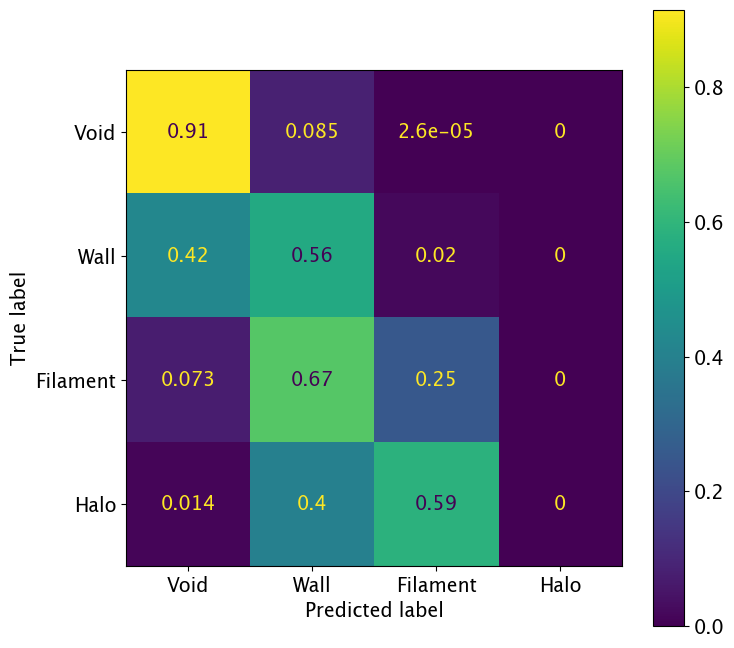

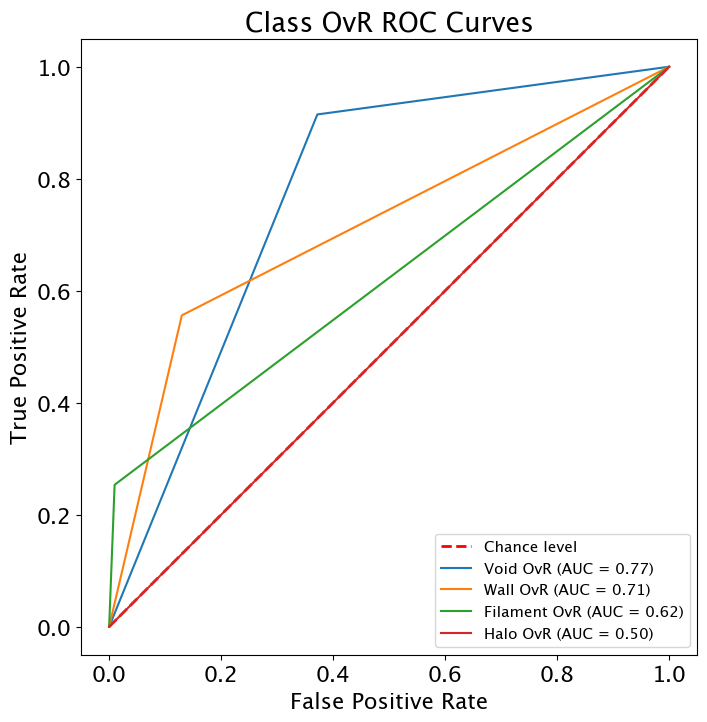

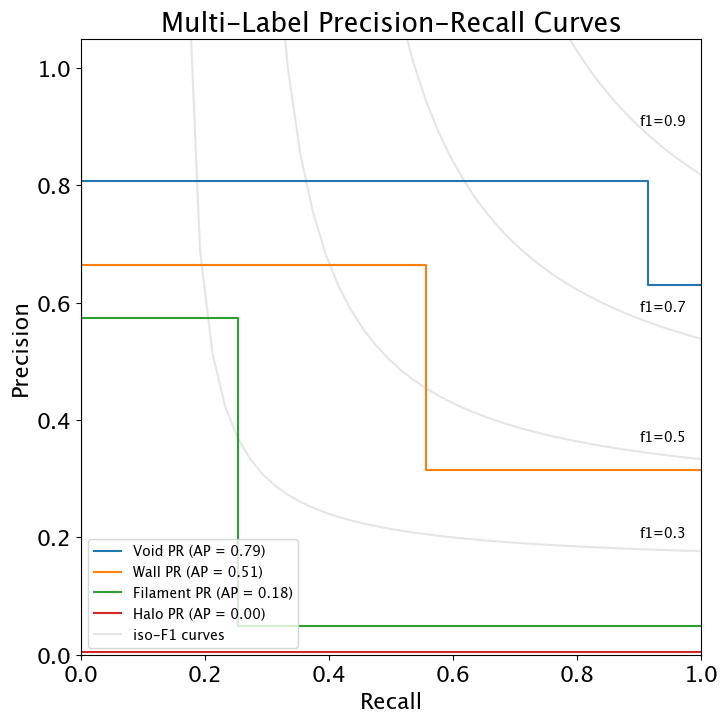

In [12]:
FIG_DIR = FIG_DIR_PATH + MODEL_NAME + '/'
if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)
    print(f'>>> Created directory {FIG_DIR}')
nets.save_scores_from_fvol(Y_test.flatten(),Y_pred.flatten(),FILE_OUT+MODEL_NAME,FIG_DIR, FILE_DEN)

In [13]:
vals, cnts = np.unique(Y_pred,return_counts=True)
print('Predicted class counts: ',dict(zip(vals,cnts)))
vals, cnts = np.unique(Y_test,return_counts=True)
print('True class counts: ',dict(zip(vals,cnts)))

Predicted class counts:  {0: 1216486, 1: 450410, 2: 37040}
True class counts:  {0: 1073624, 1: 537929, 2: 83886, 3: 8497}


`save_scores_from_model` is a function that runs the model's prediction on the entire density cube, i.e. data it has seen before. Therefore any classification metrics produced by this function are not reliable, and as such will only output scores if TRAIN_SCORE = True.

This function will compute the model's prediction, and create a couple of slice plots to visualize the model's performance.

>>> Reading volume of size: 128 128 128
Ran preprocessing to scale density to [0,1]!


2024-04-23 17:01:06.257684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Wrote prediction to /Users/samkumagai/Desktop/Drexel/DeepVoid/preds/TNG_D3-F4-Nm128-th0.65-sig0.6-base_L0.33-pred.fvol
>>> Reading volume of size: 128 128 128
>>> Reading volume of size: 128 128 128
Saved comparison plot to /Users/samkumagai/Desktop/Drexel/DeepVoid/figs/P1_FIGS/TNG_D3-F4-Nm128-th0.65-sig0.6-base_L0.33/TNG_D3-F4-Nm128-th0.65-sig0.6-base_L0.33-pred-comp.png
Saved 3x3 comparison plot to /Users/samkumagai/Desktop/Drexel/DeepVoid/figs/P1_FIGS/TNG_D3-F4-Nm128-th0.65-sig0.6-base_L0.33/TNG_D3-F4-Nm128-th0.65-sig0.6-base_L0.33-pred-comp-3x3.png


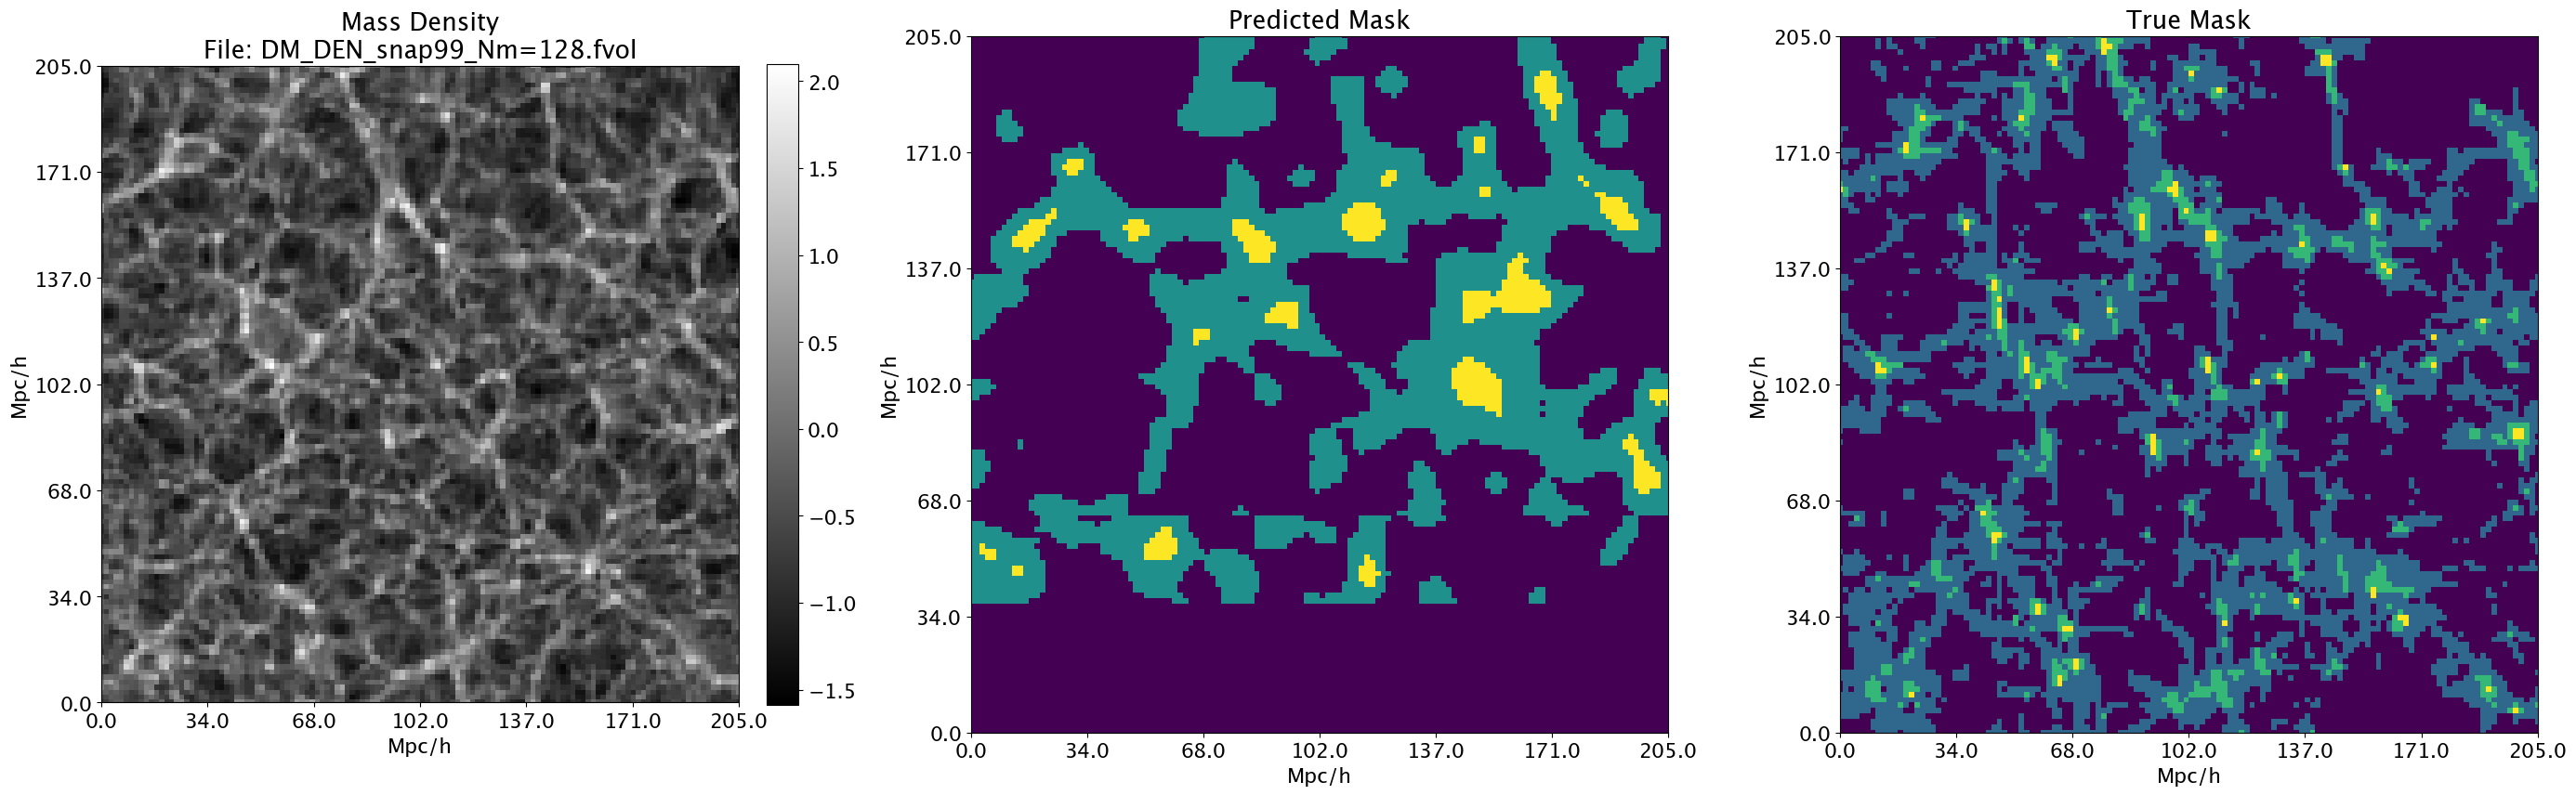

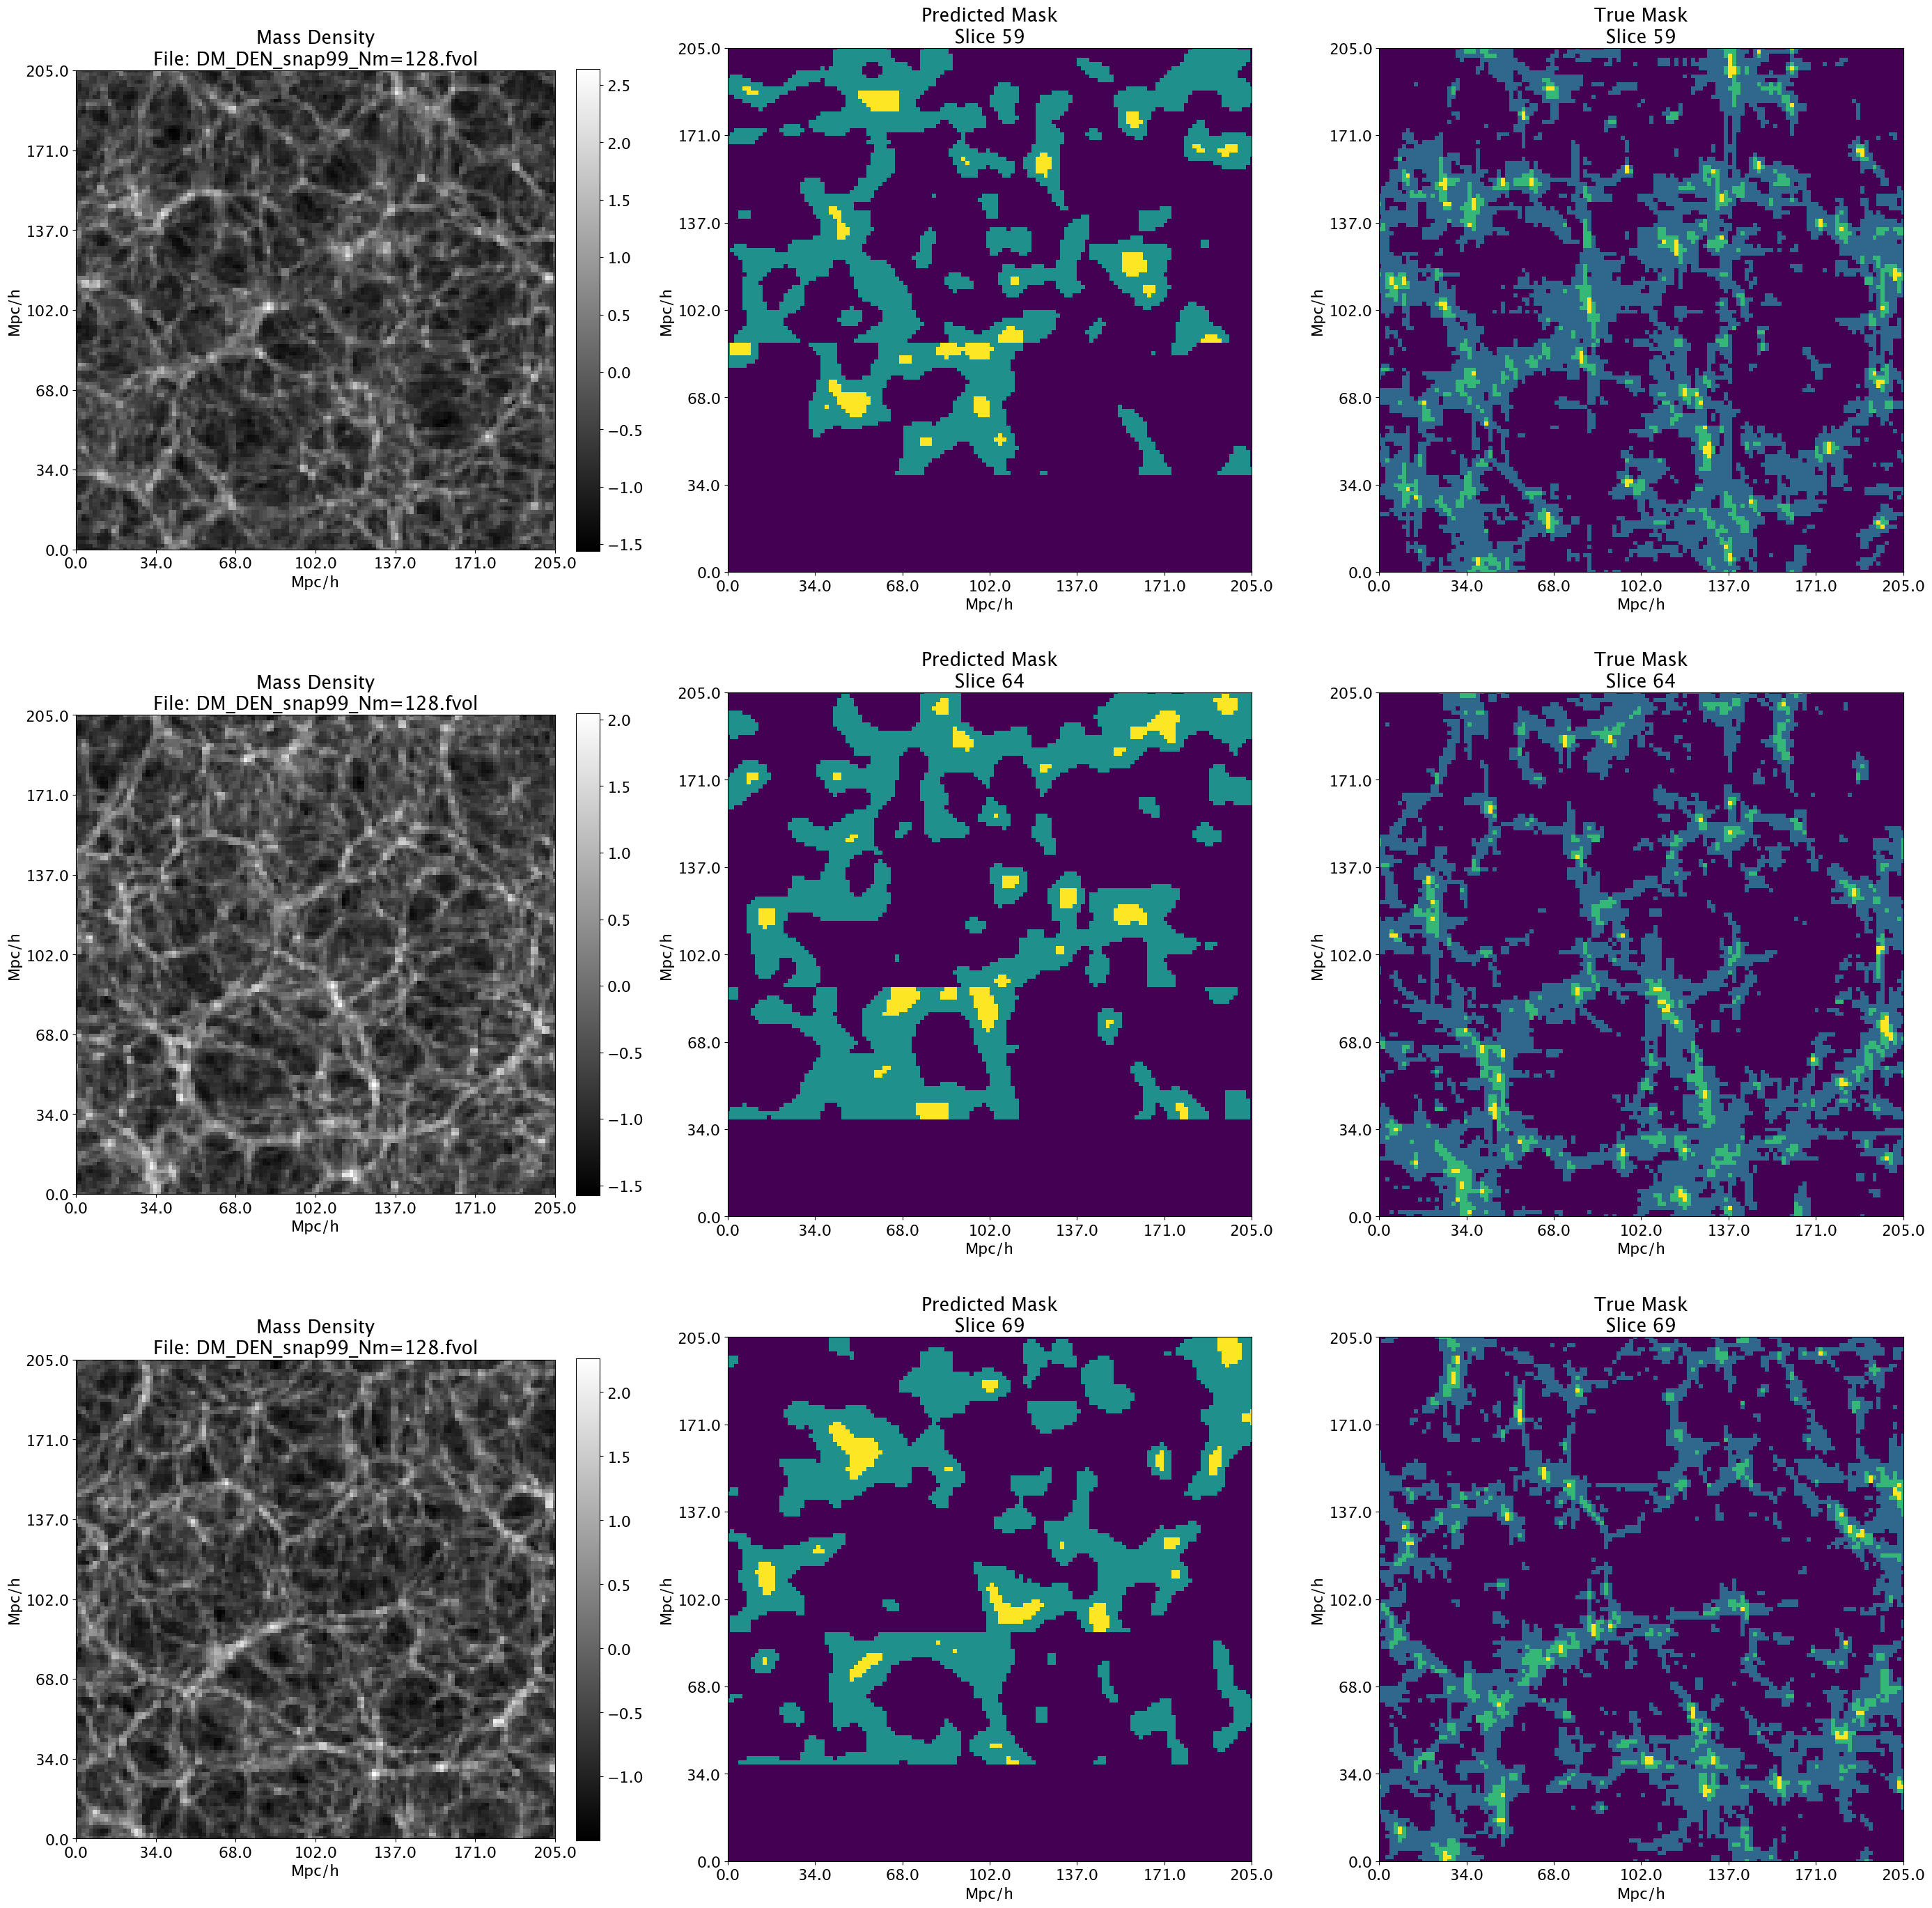

In [20]:
nets.save_scores_from_model(FILE_DEN,FILE_MSK,FILE_OUT+MODEL_NAME,FIG_DIR,FILE_PRED,
                            GRID=GRID,SUBGRID=SUBGRID,OFF=OFF,
                            TRAIN_SCORE=False)

## Plot Training Metrics from CSV Log
If, for some reason, the training metrics figure is not saved, we can plot from the .csv log file.

Log file name:
FILE_OUT (models dir) + MODEL_NAME + DATE + '_train_log.csv'

e.g. `/Users/samkumagai/Desktop/Drexel/DeepVoid/models/TNG_D2-F4-Nm128-th0.65-sig0.6-base_L0.33_FOCAL_20240423-1855_train_log.csv`

In [24]:
GRID = 128; DEPTH = 2; FILTERS= 4; th = 0.65; sig = 0.6; L = 0.33
MODEL_NAME = f'TNG_D{DEPTH}-F{FILTERS}-Nm{GRID}-th{th}-sig{sig}-base_L{L}'
MODEL_NAME += '_FOCAL' # if using focal loss
DATE = '_20240423-1855'
CSV_FILE = FILE_OUT + MODEL_NAME + DATE + '_train_log.csv'

In [33]:
import csv
CSV_LOG = {}
with open(CSV_FILE) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        for key in row.keys():
            if key not in CSV_LOG.keys():
                CSV_LOG[key] = []
            CSV_LOG[key].append(row[key])
CSV_LOG.keys()

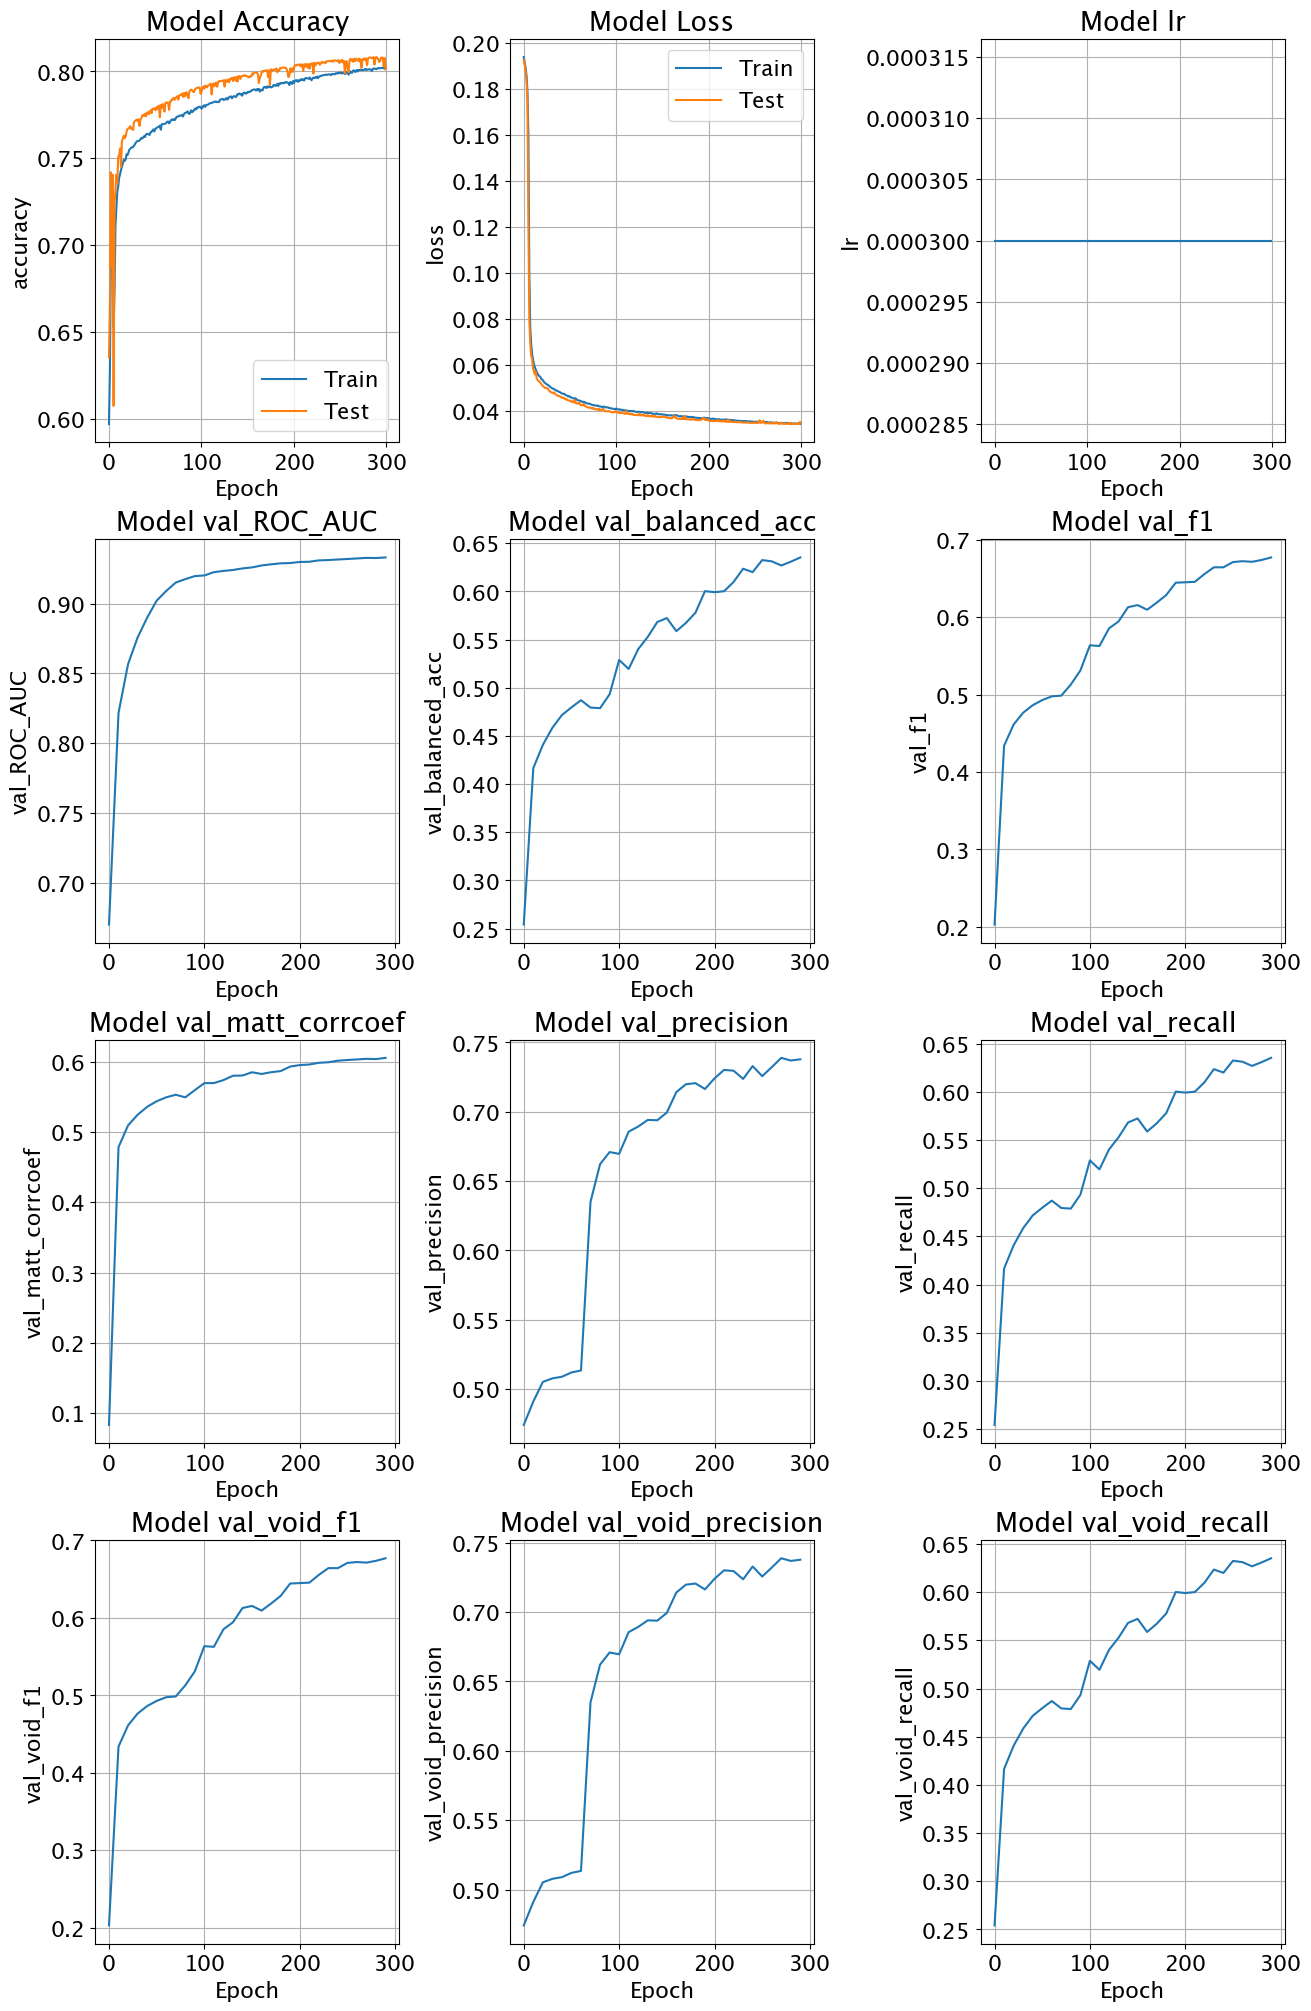

In [61]:
FIG_DIR = '/Users/samkumagai/Desktop/Drexel/DeepVoid/figs/'
FILE_METRICS = FIG_DIR + MODEL_NAME + '_metrics.png'
plotter.plot_training_metrics_all(CSV_LOG,FILE_METRICS,CSV_FLAG=True,savefig=True)